In [1]:

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

from os import listdir
from os.path import isfile, join
import pickle
from typing import Dict

import copy

# data handling
import wfdb
import pandas as pd

# graph plotting
%matplotlib ipympl
import matplotlib.pyplot as plt

import util
from util import QT_record
from util import get_record_names

from typing import List
import random

from tqdm import tqdm
import sys


In [2]:

class Config():
    ds_path = 'qt-new'
    epochs = 30
    learning_rate = 1e-3


In [3]:

class QT_Dataset(Dataset):

    def __init__(self, ds_path: str):
        self.ds_path = ds_path
        ds: List[Dict] = []
        files = [f for f in listdir(ds_path) if isfile(join(ds_path, f)) and f.endswith('.pkl') ]
        for i in files:
            i = join(ds_path, i)
            with open(i, 'rb') as f:
                ds.append(pickle.load(f))

        for i in range(0, len(ds)):
            s = ds[i].copy()
            s['data'] = torch.tensor(s['data'])
            for k in 'prt':
                s[k + '_prob'] = torch.eye(2)[int(s[k + '_prob'])]
                s[k + '_pos'] = torch.tensor(s[k + '_pos']).unsqueeze(0)
            ds[i] = s

        self.ds = ds

    def __getitem__(self, idx):
        s = self.ds[idx]
        return s['data'], s['p_prob'], s['p_pos'], s['r_prob'], s['r_pos'], s['t_prob'], s['t_pos']

    def __len__(self):
        return len(self.ds)

def QT_Dataloader(ds_path: str, batch_size: int = 100, 
                  test_percent: float = 0.3, shuffle: bool = False
                ) -> tuple[DataLoader, DataLoader, DataLoader]:

    ds = QT_Dataset(ds_path)

    train_len = len(ds)
    test_len = int(train_len * test_percent)
    train_len -= test_len

    train_ds, test_ds = torch.utils.data.random_split(ds, [train_len, test_len])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=shuffle)

    return train_loader, test_loader


In [4]:

def clone(obj):
    return copy.deepcopy(obj)

class FCN_100(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        # out = (in - kern) / stride + 1
        # input: 1x100
        # output neuron should have a receptive field size of 150 or more

        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=6, stride=2, padding=0),   # 48
            nn.Conv1d(16, 32, kernel_size=6, stride=2, padding=0),   # 22
            nn.LeakyReLU(),

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=0),   # 20
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=0),   # 18
            nn.LeakyReLU(),

            nn.Conv1d(128, 128, kernel_size=4, stride=2, padding=0),   # 8
            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=0),   # 3
            nn.LeakyReLU(),

            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=0),   # 512x1
            nn.LeakyReLU(),
        )

        f_prob = nn.Sequential(
            nn.Conv1d(512, 2, kernel_size=1),
            nn.Softmax(dim=1),
        )
        f_pos = nn.Conv1d(512, 1, kernel_size=1)

        self.p_prob = clone(f_prob)
        self.p_pos = clone(f_pos)
        self.r_prob = clone(f_prob)
        self.r_pos = clone(f_pos)
        self.t_prob = clone(f_prob)
        self.t_pos = clone(f_pos)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)
        x = self.conv(x)
        ret: List[torch.Tensor] = [
            self.p_prob(x), self.r_prob(x), self.t_prob(x),
            self.p_pos(x), self.r_pos(x), self.t_pos(x),
        ]
        for i in range(0, 3):
            ret[i] = ret[i].view(ret[i].size(0), 2)
        for i in range(3, 6):
            ret[i] = ret[i].view(ret[i].size(0), 1)

        return tuple(ret)


class FCN_100_2(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        # out = (in - kern) / stride + 1
        # input: 1x100
        # output neuron should have a receptive field size of 150 or more

        final_chan = 1024

        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=6, stride=2, padding=0),   # 48
            nn.Conv1d(16, 32, kernel_size=6, stride=2, padding=0),   # 22
            nn.LeakyReLU(),

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=0),   # 20
            nn.LeakyReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=0),   # 18
            nn.LeakyReLU(),

            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=0),   # 8
            nn.LeakyReLU(),
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=0),   # 3
            nn.LeakyReLU(),

            nn.Conv1d(512, final_chan, kernel_size=3, stride=1, padding=0),   # 1024x1
            nn.LeakyReLU(),
        )

        f_prob = nn.Sequential(
            nn.Conv1d(final_chan, 2, kernel_size=1),
            nn.LeakyReLU(),
            nn.Softmax(dim=1),
        )
        f_pos = nn.Sequential(
            nn.Conv1d(final_chan, 1, kernel_size=1),
            nn.LeakyReLU(),
        )

        self.p_prob = clone(f_prob)
        self.p_pos = clone(f_pos)
        self.r_prob = clone(f_prob)
        self.r_pos = clone(f_pos)
        self.t_prob = clone(f_prob)
        self.t_pos = clone(f_pos)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)
        x = self.conv(x)
        ret: List[torch.Tensor] = [
            self.p_prob(x), self.r_prob(x), self.t_prob(x),
            self.p_pos(x), self.r_pos(x), self.t_pos(x),
        ]
        for i in range(0, 3):
            ret[i] = ret[i].view(ret[i].size(0), 2)
        for i in range(3, 6):
            ret[i] = ret[i].view(ret[i].size(0), 1)

        return tuple(ret)

class CNN(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        # out = (in - kern) / stride + 1
        # input: 1x100
        # output neuron should have a receptive field size of 150 or more

        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=6, stride=2, padding=0),   # 48
            nn.Conv1d(16, 32, kernel_size=6, stride=2, padding=0),   # 22
            nn.LeakyReLU(),

            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=0),   # 20
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=0),   # 18
            nn.LeakyReLU(),

            nn.Conv1d(128, 256, kernel_size=4, stride=2, padding=0),   # 8
            nn.Conv1d(256, 512, kernel_size=4, stride=2, padding=0),   # 512x3
            nn.LeakyReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(1536, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
        )

        f_prob = nn.Sequential(
            nn.Linear(256, 2),
            nn.Softmax(dim=1),
        )
        f_pos = nn.Linear(256, 1)

        self.p_prob = clone(f_prob)
        self.p_pos = clone(f_pos)
        self.r_prob = clone(f_prob)
        self.r_pos = clone(f_pos)
        self.t_prob = clone(f_prob)
        self.t_pos = clone(f_pos)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        ret: List[torch.Tensor] = [
            self.p_prob(x), self.r_prob(x), self.t_prob(x),
            self.p_pos(x), self.r_pos(x), self.t_pos(x),
        ]
        for i in range(0, 3):
            ret[i] = ret[i].view(ret[i].size(0), 2)
        for i in range(3, 6):
            ret[i] = ret[i].view(ret[i].size(0), 1)

        return tuple(ret)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model = CNN().to(device)
model = FCN_100().to(device)
model.float()
print("Using {} for training".format(device))

Using cpu for training


train epoch[1/30] loss:1.635: 100%|██████████| 72/72 [00:03<00:00, 20.83it/s]
avg train loss: 2.3874614238739014; acc: 0.624
100%|██████████| 31/31 [00:00<00:00, 83.00it/s]
avg val loss: 1.6823492050170898; acc: 0.812
train epoch[2/30] loss:1.393: 100%|██████████| 72/72 [00:03<00:00, 22.65it/s]
avg train loss: 1.5335111618041992; acc: 0.849
100%|██████████| 31/31 [00:00<00:00, 71.03it/s]
avg val loss: 1.4646885395050049; acc: 0.865
train epoch[3/30] loss:1.305: 100%|██████████| 72/72 [00:03<00:00, 22.46it/s]
avg train loss: 1.3933773040771484; acc: 0.890
100%|██████████| 31/31 [00:00<00:00, 71.88it/s]
avg val loss: 1.3459768295288086; acc: 0.900
train epoch[4/30] loss:1.269: 100%|██████████| 72/72 [00:03<00:00, 22.21it/s]
avg train loss: 1.312849521636963; acc: 0.908
100%|██████████| 31/31 [00:00<00:00, 83.36it/s]
avg val loss: 1.3313970565795898; acc: 0.905
train epoch[5/30] loss:1.262: 100%|██████████| 72/72 [00:03<00:00, 23.78it/s]
avg train loss: 1.285049557685852; acc: 0.917
100%|

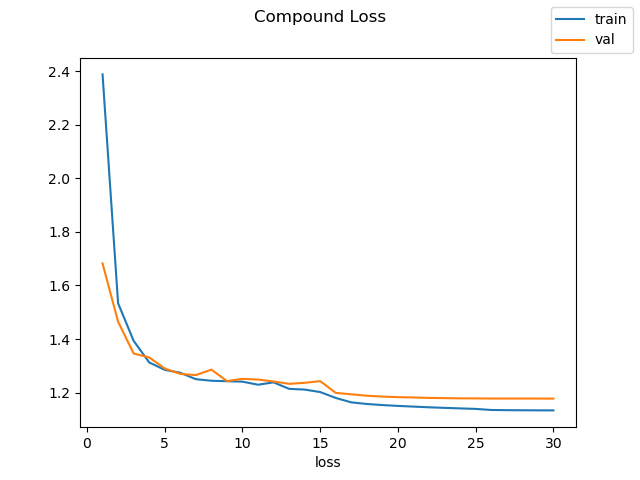

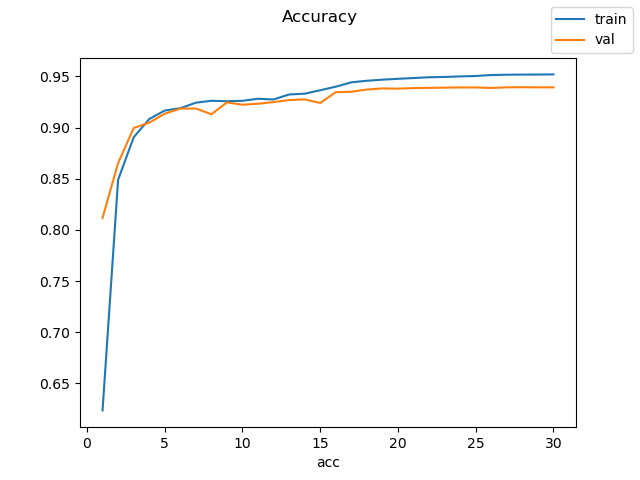

In [21]:
from time import sleep


batch_size = 100
learning_rate = 1e-3
epochs = 30

#torch.manual_seed(12345)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15,25], gamma=0.1)
prob_crit = torch.nn.CrossEntropyLoss()
pos_crit = torch.nn.MSELoss()
#pos_crit = torch.nn.SmoothL1Loss()

def evaluate(model: torch.nn.Module, loader: DataLoader) \
            -> tuple[float, float]:
    model.eval()
    correct = 0
    total = len(loader.dataset)
    #print("total: {}".format(total))
    val_bar = tqdm(loader, file=sys.stdout)
    total_loss = 0.0
    total_prob_loss = 0.0
    total_pos_loss = 0.0
    iter_cnt = 0
    for data in val_bar:
        
        for i in range(0, len(data)):
            data[i] = data[i].float()
            data[i] = data[i].to(device)
        (x, p_prob, p_pos, r_prob, r_pos, t_prob, t_pos) = data

        with torch.no_grad():
            y = model(x)
            y_p_prob, y_r_prob, y_t_prob = y[:3]
            y_p_pos, y_r_pos, y_t_pos = y[3:]

            prob_loss = prob_crit(p_prob, y[0]) + prob_crit(r_prob, y[1]) + prob_crit(t_prob, y[2])
            pos_loss = pos_crit(p_pos, y[3]) + pos_crit(r_pos, y[4]) + pos_crit(t_pos, y[5])
            total_loss += prob_loss + pos_loss
            total_prob_loss += prob_loss
            total_pos_loss += pos_loss

            pred_p = y_p_prob.argmax(dim=1)
            pred_r = y_r_prob.argmax(dim=1)
            pred_t = y_t_prob.argmax(dim=1)

            #print("pred_p.shape: {}; p_prob.argmax().shape: {}".format(pred_p.shape, p_prob.argmax(dim=1).shape))
            correct += torch.eq(pred_p, p_prob.argmax(dim=1)).sum().item()
            correct += torch.eq(pred_r, r_prob.argmax(dim=1)).sum().item()
            correct += torch.eq(pred_t, t_prob.argmax(dim=1)).sum().item()

            iter_cnt += 1

    #print("iter_cnt: {}".format(iter_cnt))
    #print("correct: {}".format(correct))
    return (correct / (3 * total), total_loss / iter_cnt, total_prob_loss / iter_cnt, total_pos_loss / iter_cnt)
    #return (correct / total, total_loss / iter_cnt)


train_loader, test_loader = QT_Dataloader(
    Config.ds_path,
    batch_size=batch_size,
    test_percent=0.3,
    shuffle=False,
)

train_losses, val_losses = [], []
train_prob_losses, train_pos_losses, val_prob_losses, val_pos_losses = [], [], [], []
train_accs, val_accs = [], []

best_acc, best_epoch = 0, 0
global_step = 0

for epoch in range(epochs):

    train_tqdm = tqdm(train_loader, file=sys.stdout)

    epoch_loss = 0
    epoch_prob_loss = 0
    epoch_pos_loss = 0
    step_count = 0

    correct = 0

    for step, data in enumerate(train_tqdm):

        for i in range(0, len(data)):
            data[i] = data[i].float()
            data[i] = data[i].to(device)
        (x, p_prob, p_pos, r_prob, r_pos, t_prob, t_pos) = data

        model.train()
        y = model(x)
        y_p_prob, y_r_prob, y_t_prob = y[:3]
        y_p_pos, y_r_pos, y_t_pos = y[3:]

        prob_loss = prob_crit(p_prob, y[0]) + prob_crit(r_prob, y[1]) + prob_crit(t_prob, y[2])
        pos_loss = pos_crit(p_pos, y[3]) + pos_crit(r_pos, y[4]) + pos_crit(t_pos, y[5])

        loss = prob_loss + pos_loss
        epoch_loss += loss
        epoch_prob_loss += prob_loss
        epoch_pos_loss += pos_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute accuracy
        
        pred_p = y_p_prob.argmax(dim=1)
        pred_r = y_r_prob.argmax(dim=1)
        pred_t = y_t_prob.argmax(dim=1)

        correct += torch.eq(pred_p, p_prob.argmax(dim=1)).sum().item()
        correct += torch.eq(pred_r, r_prob.argmax(dim=1)).sum().item()
        correct += torch.eq(pred_t, t_prob.argmax(dim=1)).sum().item()

        train_tqdm.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1, epochs, loss)
        global_step += 1
        step_count += 1
    
    scheduler.step()

    epoch_loss /= step_count
    epoch_prob_loss /= step_count
    epoch_pos_loss /= step_count
    train_acc = correct / (3 * len(train_loader.dataset))
    print('avg train loss: {}; acc: {:.3f}'.format(epoch_loss, train_acc))
    train_losses.append(epoch_loss.item())
    train_prob_losses.append(epoch_prob_loss.item())
    train_pos_losses.append(epoch_pos_loss.item())
    train_accs.append(train_acc)

    val_acc, val_loss, val_prob_loss, val_pos_loss = evaluate(model, test_loader)

    print('avg val loss: {}; acc: {:.3f}'.format(val_loss, val_acc))
    val_losses.append(val_loss.item())
    val_prob_losses.append(val_prob_loss.item())
    val_pos_losses.append(val_pos_loss.item())
    val_accs.append(val_acc)

    if val_acc > best_acc:
        best_epoch = epoch
        best_acc = val_acc
        torch.save(model.state_dict(), 'best.pt')

print('best acc: {:.3f}, at epoch {}.'.format(best_acc, best_epoch))

model.load_state_dict(torch.load('best.pt'))
print('loaded from checkpoint!'); 

x_data = range(1, epochs + 1)

# Compound loss plot

fig, ax = plt.subplots()
fig.suptitle('Compound Loss')
ax.set_xlabel('epochs')
ax.set_xlabel('loss')

ax.plot(x_data, train_losses, label='train')
ax.plot(x_data, val_losses, label='val')
fig.legend()
fig.savefig('loss_graph.jpg')

# Accuracy plot

fig, ax = plt.subplots()
fig.suptitle('Accuracy')
ax.set_xlabel('epochs')
ax.set_xlabel('acc')

ax.plot(x_data, train_accs, label='train')
ax.plot(x_data, val_accs, label='val')
fig.legend()
fig.savefig('acc_graph.jpg')




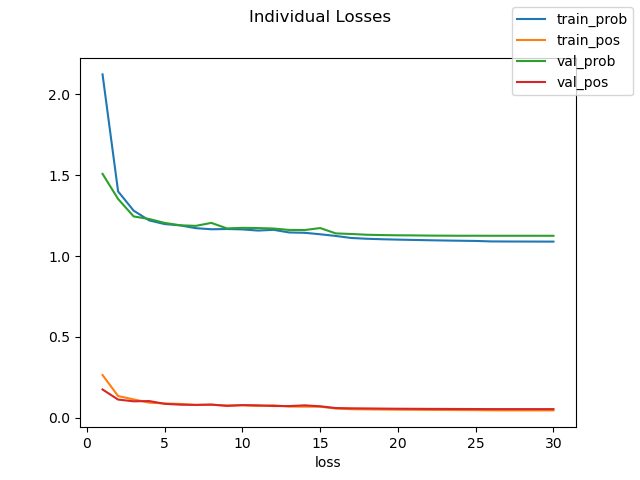

In [22]:


# Individual loss plot

fig, ax = plt.subplots()
fig.suptitle('Individual Losses')
ax.set_xlabel('epochs')
ax.set_xlabel('loss')

ax.plot(x_data, train_prob_losses, label='train_prob')
ax.plot(x_data, train_pos_losses, label='train_pos')
ax.plot(x_data, val_prob_losses, label='val_prob')
ax.plot(x_data, val_pos_losses, label='val_pos')
fig.legend()
fig.savefig('indiv_loss_graph.jpg')
